<a href="https://colab.research.google.com/github/fionarice63/colorectal_histology_project/blob/main/full_ml_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.4 MB/s eta 0:00:00


In [ ]:

import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from kerastuner.tuners import RandomSearch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.svm import SVC



<ipython-input-2-381e753c441d>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
data_dir =  "/content/drive/MyDrive/Kather_texture_2016_image_tiles_2000"
class_names = sorted(os.listdir(data_dir))
num_classes = len(class_names)

img_height = 150
img_width = 150


In [ ]:
#create a function to load all the images and labels from dataset:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image

def load_images_and_labels(data_dir, class_names, img_height, img_width):
    images = []
    labels = []
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = image.load_img(img_path, target_size=(img_height, img_width))
            img_array = image.img_to_array(img)
            images.append(img_array)
            labels.append(class_index)
    return np.array(images), np.array(labels)


In [ ]:
#Load all the images and labels using the function:
images, labels = load_images_and_labels(data_dir, class_names, img_height, img_width)



In [ ]:

# Split the data into a train and temporary set (80% train, 20% temp)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

# Split the temporary set into validation and test sets (10% validation, 10% test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)



In [ ]:
#Create the ImageDataGenerator instances for train, validation, and test sets:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32


In [ ]:
#Create the data generators for train, validation, and test sets:
train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_gen = val_datagen.flow(X_val, y_val, batch_size=batch_size)
test_gen = test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)


In [ ]:
# Define the model builder function
def build_model(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add a varying number of Dense layers
    for i in range(hp.Int("num_dense_layers", min_value=1, max_value=3, step=1)):
        x = Dense(units=hp.Int("units_" + str(i), min_value=256, max_value=1024, step=256), activation="relu")(x)

    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float("learning_rate", min_value=1e-5, max_value=1e-3, sampling="LOG")),
                  loss='sparse_categorical_crossentropy',  # Change the loss to sparse_categorical_crossentropy
                  metrics=['accuracy'])

    return model




In [ ]:
# Set up the hyperparameter tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='output',
    project_name='HyperparameterTuning'
)


58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# Start the hyperparameter tuning process
tuner.search(train_gen,
             epochs=10,
             validation_data=val_gen,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)],
             verbose=1
             )

tuner.results_summary()



Trial 10 Complete [00h 00m 24s]
val_accuracy: 0.8894472122192383

Best val_accuracy So Far: 0.8894472122192383
Total elapsed time: 00h 04m 18s
Results summary
Results in output/HyperparameterTuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
num_dense_layers: 3
units_0: 512
learning_rate: 0.00021500738122916943
units_1: 768
units_2: 768
Score: 0.8894472122192383

Trial 01 summary
Hyperparameters:
num_dense_layers: 2
units_0: 256
learning_rate: 0.0008593307202512103
units_1: 768
units_2: 256
Score: 0.8844221234321594

Trial 03 summary
Hyperparameters:
num_dense_layers: 3
units_0: 256
learning_rate: 0.0006255209054387566
units_1: 768
units_2: 256
Score: 0.8793969750404358

Trial 00 summary
Hyperparameters:
num_dense_layers: 3
units_0: 256
learning_rate: 0.0002776217244607687
units_1: 256
units_2: 256
Score: 0.8743718862533569

Trial 05 summary
Hyperparameters:
num_dense_layers: 3
units_0: 1024
learning_rate: 6.615540820355941e

hyperparmaeter tuning done the following code saves this so that this doesnt neeed to be reran 


In [ ]:
import json

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters_dict = best_hyperparameters.get_config()['values']

with open("best_hyperparameters.json", "w") as outfile:
    json.dump(best_hyperparameters_dict, outfile)


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save("best_model.h5")

best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

the following code is a way to load into the script the presaved hypermapareters and best model


In [ ]:
#load
with open("best_hyperparameters.json", "r") as infile:
    best_hyperparameters_dict = json.load(infile)

#Load the best model
best_model = tf.keras.models.load_model("best_model.h5")


In [ ]:
# Get the best model
#best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
full_cnn_model = build_model(best_hyperparameters)

# Fine-tune the model
history = full_cnn_model.fit(train_gen,
                             epochs=10,
                             validation_data=val_gen,
                             callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)])


Epoch 1/10
50/50 [==============================] - 6s 39ms/step - loss: 1.3423 - accuracy: 0.5567 - val_loss: 0.8249 - val_accuracy: 0.7286
Epoch 2/10
50/50 [==============================] - 2s 32ms/step - loss: 0.6554 - accuracy: 0.7783 - val_loss: 0.5032 - val_accuracy: 0.8191
Epoch 3/10
50/50 [==============================] - 2s 35ms/step - loss: 0.5103 - accuracy: 0.8186 - val_loss: 0.4563 - val_accuracy: 0.8291
Epoch 4/10
50/50 [==============================] - 2s 33ms/step - loss: 0.4508 - accuracy: 0.8501 - val_loss: 0.3850 - val_accuracy: 0.8844
Epoch 5/10
50/50 [==============================] - 2s 33ms/step - loss: 0.3796 - accuracy: 0.8728 - val_loss: 0.3735 - val_accuracy: 0.8794
Epoch 6/10
50/50 [==============================] - 2s 35ms/step - loss: 0.3268 - accuracy: 0.8961 - val_loss: 0.4227 - val_accuracy: 0.8392
Epoch 7/10
50/50 [==============================] - 2s 33ms/step - loss: 0.3249 - accuracy: 0.8892 - val_loss: 0.3894 - val_accuracy: 0.8593
Epoch 8/10
50

Now to evaluate the performance of the full CNN


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = full_cnn_model.evaluate(test_gen)

print("Test Loss: {:.4f}".format(test_loss))
print("Test Accuracy: {:.4f}".format(test_accuracy))


7/7 [==============================] - 0s 27ms/step - loss: 0.5405 - accuracy: 0.8241
Test Loss: 0.5405
Test Accuracy: 0.8241


In [ ]:
#getting metrics!! FOR CNN alone

# Get true labels and predictions
y_pred = full_cnn_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='weighted')
report = classification_report(y_test, y_pred_classes, target_names=class_names)

# Print metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nROC-AUC Score: {:.4f}".format(roc_auc))
print("\nClassification Report:\n", report)



7/7 [==============================] - 1s 28ms/step
Accuracy: 0.8241
Precision: 0.8325
Recall: 0.8241
F1-score: 0.8195

Confusion Matrix:
 [[23  0  0  1  0  0  1  0]
 [ 0 12  7  0  4  1  1  0]
 [ 1  1 21  1  0  1  0  0]
 [ 1  1  3 18  0  1  0  0]
 [ 1  1  0  0 22  0  1  0]
 [ 3  0  2  0  0 20  0  0]
 [ 0  0  0  0  0  0 24  1]
 [ 0  0  0  0  0  0  1 24]]

ROC-AUC Score: 0.9791

Classification Report:
               precision    recall  f1-score   support

    01_TUMOR       0.79      0.92      0.85        25
   02_STROMA       0.80      0.48      0.60        25
  03_COMPLEX       0.64      0.84      0.72        25
   04_LYMPHO       0.90      0.75      0.82        24
   05_DEBRIS       0.85      0.88      0.86        25
   06_MUCOSA       0.87      0.80      0.83        25
  07_ADIPOSE       0.86      0.96      0.91        25
    08_EMPTY       0.96      0.96      0.96        25

    accuracy                           0.82       199
   macro avg       0.83      0.82      0.82       199


Now extracting of features for the SVM to compare

In [ ]:
# Removing the last layer and using the CNN as a feature extractor
feature_extractor = Model(inputs=full_cnn_model.input, outputs=full_cnn_model.layers[-2].output)

# Function to extract features and labels from a generator
def get_features_and_labels(generator):
    features = []
    labels = []

    for i in range(len(generator)):
        images_batch, labels_batch = generator.next()
        features_batch = feature_extractor.predict(images_batch)
        features.extend(features_batch)
        labels.extend(labels_batch)

        if generator.batch_index == 0:
            break

    return np.array(features), np.array(labels)

train_features, train_labels = get_features_and_labels(train_gen)
val_features, val_labels = get_features_and_labels(val_gen)

from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize the SVM model
svm = SVC()

# Initialize the GridSearchCV object with the SVM model, parameter grid, and desired scoring metric
grid_search = GridSearchCV(svm, param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit the GridSearchCV object to the training features and labels
grid_search.fit(train_features, train_labels)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters: ", best_params)

# Train the SVM with the best hyperparameters on the entire training set
best_svm = SVC(**best_params)
best_svm.fit(train_features, train_labels)

# Evaluate the SVM with the best hyperparameters on the validation set
svm_predictions = best_svm.predict(val_features)
print("SVM Classification Report:")
print(classification_report(val_labels, svm_predictions, target_names=class_names))

1/1 [==============================] - 0s 23ms/step
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
SVM Classification Report:
              precision    recall  f1-score   support

    01_TUMOR       0.85      0.92      0.88        25
   02_STROMA       0.79      0.88      0.83        25
  03_COMPLEX       0.72      0.72      0.72        25
   04_LYMPHO       0.95      0.79      0.86        24
   05_DEBRIS       0.91      0.80      0.85        25
   06_MUCOSA       0.89      0.96      0.92        25
  07_ADIPOSE       1.00      1.00      1.00        25
    08_EMPTY       1.00      1.00      1.00        25

    accuracy                           0.88       199
   macro avg       0.89      0.88      0.88       199
weighted avg       0.89      0.88      0.88       199



In [ ]:
# Extract features and labels for the test set
test_features, test_labels = get_features_and_labels(test_gen)

# Evaluate the SVM with the best hyperparameters on the test set
svm_test_predictions = best_svm.predict(test_features)
print("SVM Classification Report (Test Set):")
print(classification_report(test_labels, svm_test_predictions, target_names=class_names))




1/1 [==============================] - 0s 66ms/step
SVM Classification Report (Test Set):
              precision    recall  f1-score   support

    01_TUMOR       0.84      0.84      0.84        25
   02_STROMA       0.70      0.76      0.73        25
  03_COMPLEX       0.73      0.76      0.75        25
   04_LYMPHO       0.81      0.88      0.84        24
   05_DEBRIS       0.75      0.72      0.73        25
   06_MUCOSA       0.95      0.80      0.87        25
  07_ADIPOSE       0.88      0.88      0.88        25
    08_EMPTY       0.96      0.96      0.96        25

    accuracy                           0.82       199
   macro avg       0.83      0.82      0.83       199
weighted avg       0.83      0.82      0.82       199



In [ ]:
# Initialize the SVM model with probability output enabled
svm = SVC(probability=True)

# Initialize the GridSearchCV object with the SVM model, parameter grid, and desired scoring metric
grid_search = GridSearchCV(svm, param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit the GridSearchCV object to the training features and labels
grid_search.fit(train_features, train_labels)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters: ", best_params)

# Train the SVM with the best hyperparameters on the entire training set
best_svm = SVC(**best_params, probability=True)
best_svm.fit(train_features, train_labels)

# Get probability estimates for the test set
svm_test_probs = best_svm.predict_proba(test_features)

# Calculate ROC-AUC score for the SVM model
svm_roc_auc = roc_auc_score(test_labels, svm_test_probs, multi_class='ovr', average='weighted')
print("SVM ROC-AUC Score: {:.4f}".format(svm_roc_auc))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
SVM ROC-AUC Score: 0.9813


In [ ]:
import pickle

# Save the feature extractor
with open("feature_extractor.pkl", "wb") as file:
    pickle.dump(feature_extractor, file)

# Save the best SVM model
with open("best_svm.pkl", "wb") as file:
    pickle.dump(best_svm, file)


to do: metrics to comapre the two

Clustering now on the extracted variables

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

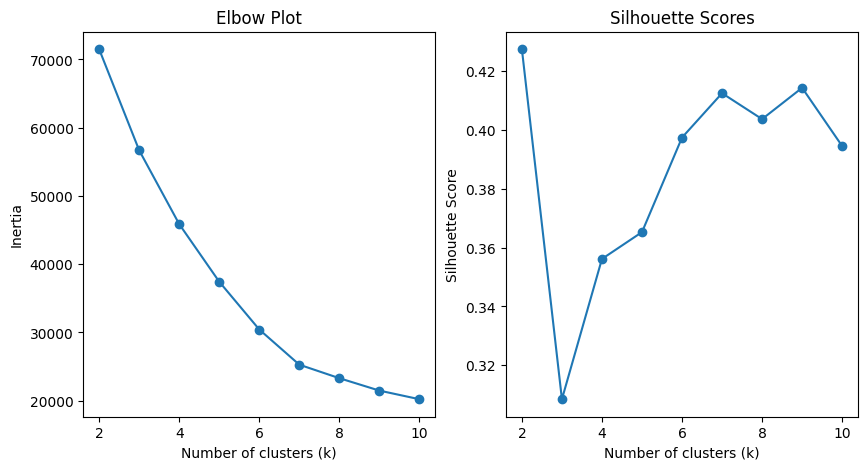

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Combine train and validation features for clustering
all_features = np.concatenate([train_features, val_features], axis=0)

# Define the range of k values to test
k_range = range(2, 11)

# Calculate the inertia and silhouette scores for each k
inertia = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(all_features)
    
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(all_features, kmeans.labels_))

# Plot the elbow plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Plot')

# Plot the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')

plt.show()

In [ ]:
# Combine train and validation features for clustering
all_features = np.concatenate([train_features, val_features], axis=0)
all_labels = np.concatenate([train_labels, val_labels], axis=0)

# Perform K-means clustering
kmeans = KMeans(n_clusters=8, random_state=42)
cluster_assignments = kmeans.fit_predict(all_features)

# Visualize the clustering results using a confusion matrix
confusion = confusion_matrix(all_labels, cluster_assignments)
confusion

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([[  0,   1,   1, 215,   1,   0,   1,   6],
       [  0,   0,   0,   0,  30,   0, 136,  59],
       [  0,   1,  17,  14,   5,   0,   3, 185],
       [  0,   1, 191,   1,   0,   0,   0,  19],
       [  1,   3,   0,   2, 205,   1,   1,  12],
       [  0, 211,   4,   2,   0,   0,   0,   8],
       [ 29,   0,   0,   0,   3, 193,   0,   0],
       [225,   0,   0,   0,   0,   0,   0,   0]])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix


<ipython-input-27-f5c724883527>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', 8)  # Use the same number of clusters you used in KMeans


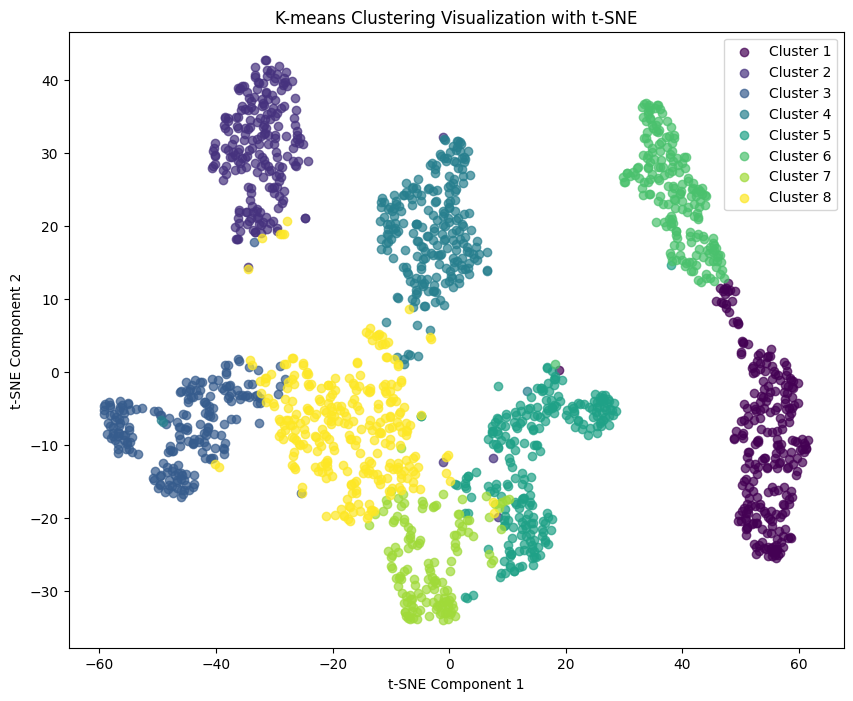

In [ ]:
# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
all_features_2d = tsne.fit_transform(all_features)

# Create a scatter plot with different colors for each cluster
colors = plt.cm.get_cmap('viridis', 8)  # Use the same number of clusters you used in KMeans
plt.figure(figsize=(10, 8))

for i in range(8):  # Use the same number of clusters you used in KMeans
    plt.scatter(all_features_2d[cluster_assignments == i, 0], all_features_2d[cluster_assignments == i, 1],
                color=colors(i), label=f'Cluster {i + 1}', alpha=0.7)

plt.legend()
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('K-means Clustering Visualization with t-SNE')
plt.show()

<ipython-input-42-abc4fbefe889>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 8)  # Use the 'tab10' colormap with the same number of classes as in your dataset


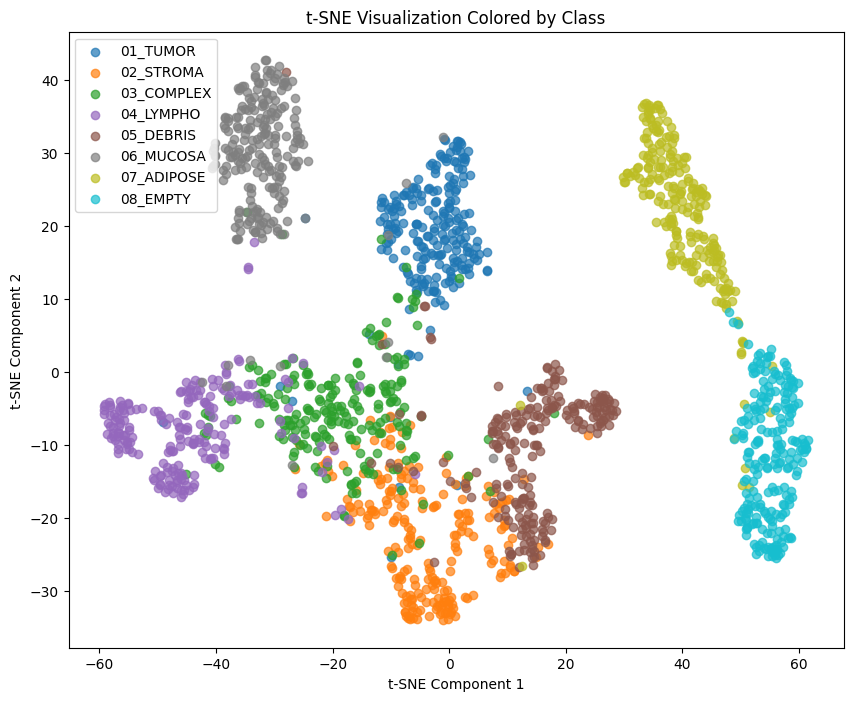

In [ ]:
class_names = ['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY']

# Create a scatter plot with different colors for each class
colors = plt.cm.get_cmap('tab10', 8)  # Use the 'tab10' colormap with the same number of classes as in your dataset
plt.figure(figsize=(10, 8))

for i in range(8):  # Use the same number of classes as in your dataset
    plt.scatter(all_features_2d[all_labels == i, 0], all_features_2d[all_labels == i, 1],
                color=colors(i), label=f'{class_names[i]}', alpha=0.7)

plt.legend()
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization Colored by Class')
plt.show()



In [ ]:
test_features, test_labels = get_features_and_labels(test_gen)
svm_probs = best_svm.decision_function(test_features)


1/1 [==============================] - 0s 22ms/step


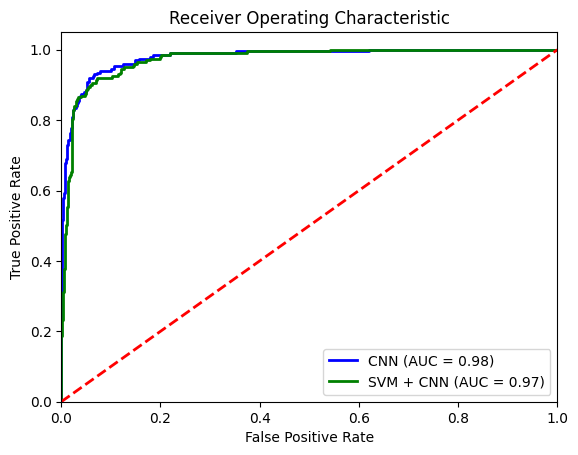

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels for multi-class ROC curve
y_test_bin = label_binarize(y_test, classes=range(num_classes))
test_labels_bin = label_binarize(test_labels, classes=range(num_classes))

# Calculate ROC curve data for the CNN model
fpr_cnn, tpr_cnn, _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# Calculate ROC curve data for the SVM + CNN model
fpr_svm, tpr_svm, _ = roc_curve(test_labels_bin.ravel(), svm_probs.ravel())
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot the ROC curve for both models
plt.figure()
plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2, label='CNN (AUC = %0.2f)' % roc_auc_cnn)
plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label='SVM + CNN (AUC = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
